# Flipkart Laptop Review Topic Modeling

In [12]:
# Import Library
import os
import pandas as pd
import spacy
import gensim
import kagglehub
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics import silhouette_score

RANDOM_STATE = 555

ModuleNotFoundError: No module named 'sklearn'

# Data Collection and Preprocessing
- Collect relevant datasets.
- Preprocess the text data that will involve different NLP tasks where needed.
- Split the dataset into a training set and a test set.


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gitadityamaddali/flipkart-laptop-reviews")
df = pd.read_csv(os.path.join(path, "laptops_dataset_final_600.csv"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24113 entries, 0 to 24112
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    24113 non-null  object 
 1   overall_rating  24113 non-null  float64
 2   no_ratings      24113 non-null  object 
 3   no_reviews      24113 non-null  object 
 4   rating          24113 non-null  int64  
 5   title           24113 non-null  object 
 6   review          24113 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB


In [8]:
# Exploratory Data Analysis
df['title_length'] = df['title'].apply(len)
df['review_length'] = df['review'].apply(len)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))


sns.histplot(df['title_length'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Title Lengths')
ax[0].set_xlabel('Title Length')

sns.histplot(df['review_length'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Review Lengths')
ax[1].set_xlabel('Review Length') 

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")

# Get the default stop words
default_stops = nlp.Defaults.stop_words

# Remove negation words from stop words
negation_words = {'no', 'not', 'nor', 'neither', 'never', "n't", "ain't", "aren't", 
                 "can't", "couldn't", "didn't", "doesn't", "don't", "hasn't", 
                 "haven't", "isn't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't"}

# Remove negation words from stop words
custom_stop_words = default_stops.union(negation_words)

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.text.lower() not in custom_stop_words and 
                                                                          not token.is_punct]
    return " ".join(tokens)
 
df['combined_text'] = df['title'] + " " + df['review']
df['combined_processed'] = df['combined_text'].apply(preprocess_text)

df.drop(columns=['title', 
                 'review',
                 'title_length', 
                 'review_length'], inplace=True)

df.head()


## Feature Extraction and Feature Engineering (3+3 = 6 marks)
- Extract and select numerical features from text data using NLP techniques - Bag of Words (BoW), TF-IDF, or word embeddings (Word2Vec, GloVe).

In [ ]:
# Using Gensim for Bag of Words (BoW) feature extraction
import gensim
from gensim import corpora
from gensim.models import TfidfModel
import numpy as np
from sklearn.model_selection import train_test_split

# Create a list of tokenized documents
tokenized_docs = [doc.split() for doc in df['combined_processed']]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out extreme values (optional)
# Remove words that appear in less than 5 documents or more than 50% of documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert tokenized documents to BoW format
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

print(f"Dictionary size: {len(dictionary)} terms") 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# BoW
bow_vectorizer = CountVectorizer(min_df=5, max_df=0.5)
bow_vectors = bow_vectorizer.fit_transform(df['combined_processed'])
print(bow_vectors.shape)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.5)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['combined_processed'])
print(tfidf_vectors.shape)


(24113, 2483)
(24113, 2483)


## Model Training and Evaluation
- Train the model on the training dataset.
- Evaluate the model using appropriate metrics:
  - Classification: Accuracy, Precision, Recall, F1-Score.
  - Topic Modeling: Perplexity, Topic Coherence.
- Fine-tune model parameters for optimal performance.


In [ ]:
# Create train/test split
X_train, X_test = train_test_split(bow_vectors, test_size=0.2, random_state=555)

# Function to evaluate different numbers of topics
def evaluate_lda_topics(min_topics=2, max_topics=15, step=1):
    topics_range = range(min_topics, max_topics + 1, step)
    perplexity_scores = []
    silhouette_scores = []
    
    # Evaluate each topic number
    for num_topics in topics_range:
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            learning_method='online',
            random_state=RANDOM_STATE
        )
        lda_output = lda.fit_transform(X_train)
        
        # Calculate metrics
        perplexity = lda.perplexity(X_test)
        perplexity_scores.append(perplexity)
         
        # Calculate silhouette score
        silhouette = calculate_silhouette(lda, X_train)
        silhouette_scores.append(silhouette)
        
        print(f"Number of topics: {num_topics} | Perplexity: {perplexity:.4f} | Silhouette: {silhouette:.4f}")
    
    return topics_range, perplexity_scores, coherence_scores, silhouette_scores

def calculate_silhouette(lda, X_train):
    lda_output = lda.transform(X_train)
    return silhouette_score(lda_output, np.argmax(lda_output, axis=1))

topics_range, perplexity_scores, coherence_scores, silhouette_scores = evaluate_lda_topics()

Number of topics: 2 | Perplexity: 486.3460 | Silhouette: 0.6659
Number of topics: 3 | Perplexity: 526.4016 | Silhouette: 0.5291
Number of topics: 4 | Perplexity: 549.1373 | Silhouette: 0.4603
Number of topics: 5 | Perplexity: 573.7192 | Silhouette: 0.4197
Number of topics: 6 | Perplexity: 596.1788 | Silhouette: 0.3971
Number of topics: 7 | Perplexity: 618.7384 | Silhouette: 0.3595
Number of topics: 8 | Perplexity: 641.5212 | Silhouette: 0.3267
Number of topics: 9 | Perplexity: 653.5184 | Silhouette: 0.3019
Number of topics: 10 | Perplexity: 651.9030 | Silhouette: 0.3077
Number of topics: 11 | Perplexity: 678.2408 | Silhouette: 0.2891
Number of topics: 12 | Perplexity: 705.8928 | Silhouette: 0.2909
Number of topics: 13 | Perplexity: 706.9678 | Silhouette: 0.2685
Number of topics: 14 | Perplexity: 720.8312 | Silhouette: 0.2668
Number of topics: 15 | Perplexity: 741.8999 | Silhouette: 0.2489


In [23]:
best_num_topics = topics_range[np.argmin(perplexity_scores)]
print(f"Best number of topics: {best_num_topics}")
print(f"Perplexity: {perplexity_scores[np.argmin(perplexity_scores)]}")
print(f"Silhouette: {silhouette_scores[np.argmin(perplexity_scores)]}")

lda = LatentDirichletAllocation(
    n_components=best_num_topics,
    learning_method='online',
    random_state=RANDOM_STATE
)
lda.fit(X_train)



Best number of topics: 2
Perplexity: 486.34602253806105
Silhouette: 0.6659401936057252


LatentDirichletAllocation(learning_method='online', n_components=2,
                          random_state=555)

In [26]:
# Print the top 10 words for each topic
feature_names = bow_vectorizer.get_feature_names_out()
n_top_words = 10

print(f"Top {n_top_words} words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    # Sort the terms by their importance in this topic
    top_features_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [(feature_names[i], topic[i]) for i in top_features_idx]
    
    # Print topic number and the top words with their scores
    print(f"\nTopic {topic_idx + 1}:")
    for word, score in top_features:
        print(f"  {word}: {score:.4f}")



Top 10 words for each topic:

Topic 1:
  laptop: 5431.1501
  battery: 2492.4674
  performance: 2427.8347
  price: 2364.7881
  display: 2348.7300
  awesome: 2201.9626
  purchase: 1936.2325
  quality: 1487.2626
  work: 1357.1950
  use: 1316.7797

Topic 2:
  product: 9032.4511
  nice: 3600.5348
  money: 3341.3865
  laptop: 2478.8106
  value: 2401.1853
  battery: 1744.4688
  buy: 1650.9377
  worth: 1550.3596
  quality: 1424.5755
  bad: 1248.1787


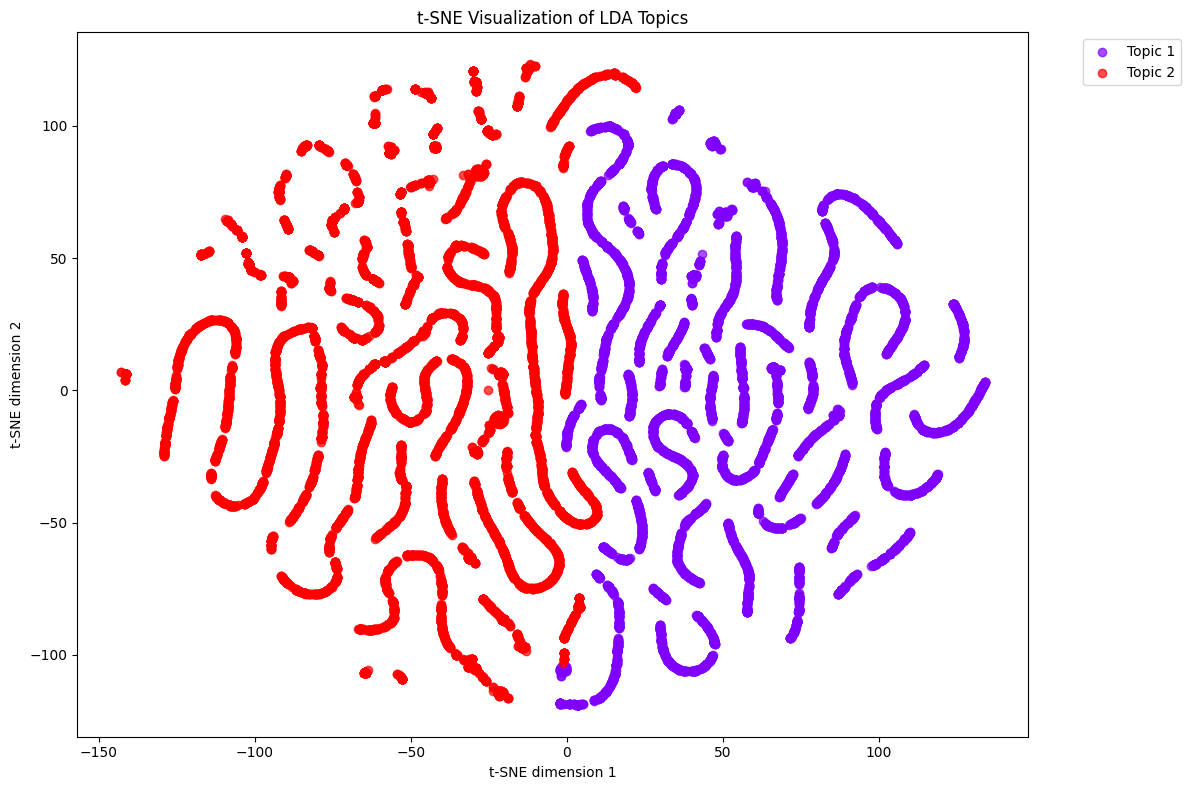

In [27]:

# Visualize the topics using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Transform the data
lda_output = lda.transform(X_train)

# Create t-SNE model
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(lda_output)

# Create a scatter plot
plt.figure(figsize=(12, 8))
colors = cm.rainbow(np.linspace(0, 1, best_num_topics))

# Get the dominant topic for each document
dominant_topics = np.argmax(lda_output, axis=1)

# Plot each document colored by its dominant topic
for topic_idx in range(best_num_topics):
    # Get indices of documents with this dominant topic
    indices = np.where(dominant_topics == topic_idx)[0]
    plt.scatter(
        tsne_results[indices, 0], 
        tsne_results[indices, 1],
        c=[colors[topic_idx]],
        label=f'Topic {topic_idx+1}',
        alpha=0.7
    )

plt.title('t-SNE Visualization of LDA Topics')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Model Refinement and Optimization
- Experiment with different autoencoder architectures, hyperparameters, and reconstruction error thresholds to fine-tune the model's performance.
- Apply techniques such as learning rate scheduling, regularization, and dropout to improve the model's generalization and robustness.


1. Hyperparameter Tuning using grid-search.
2. Use BERTopic for topic modeling.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Parameters to tune
params = {
    'n_components': [best_num_topics],
    'learning_decay': [0.5, 0.7, 0.9],
    'max_iter': [10, 20, 30],
    'doc_topic_prior': [None, 0.5, 0.9],
    'topic_word_prior': [None, 0.5, 0.9]
}

# Grid search
grid_lda = GridSearchCV(
    LatentDirichletAllocation(learning_method='online', random_state=RANDOM_STATE),
    param_grid=params
)

grid_lda.fit(bow_vectors)

# Best parameters
best_lda = grid_lda.best_estimator_

## Documentation (10 marks) and 15 mins Presentation (10 marks)
Document the entire project, including the dataset description, preprocessing steps, model architecture, hyperparameter settings, and evaluation results.

Create a presentation summarizing the project's objectives, methods, findings, and recommendations.